# COGS 118A - Final Project

# NCAA Basketball Game Predictor

## Group members

- Evan Eguchi
- Thomas Fratantoni
- Zachary Tulman
- Charles Ye

# Abstract 
In this project we attempted to create a prediction model that can produce an accurate March Madness bracket to a high degree. To this end, we sought to predict the outcome of individual matches rather than whole brackets as brackets are built by individual matches. We tested models using both Gradient Boosting Decision Tree and Logistic Regression classifiers trained on NCAA regular season data from 2003 to 2021. The models were trained and tested on the regular season data and accuracy was determined by percentage of correctly classified wins in the test set. The logistic regression ended up having the highest accuracy after preliminary testing, so we used it for our final model. Our final model is able to predict match outcomes with high accuracy based on the data we used, but we’re unsure about how it would generalize to predicting entire March Madness brackets since the vast majority of our training data comes from regular season games.

# Background

The March Madness Division I basketball tournament is an extremely popular sporting event that acts as the playoffs for collegiate men’s basketball. The format of the tournament is a single elimination, 68 team bracket played over the course of 3 weekends through March and April. The tournament began in 1939, initially only hosting 8 teams. As the Division I tournament grew in popularity, the number of teams also grew until in 1985 it expanded to its current 68 team layout and expanded its absurd probability of predicting a “perfect bracket” (a bracket that correctly predicts the winner of every game) <a name="wilco"></a>[<sup>[1]</sup>](#wilconote). Despite the 1 in 9.2 quintillion odds, every year millions of people take a shot at filling out their own bracket, and it has become a fun tradition for March Madness enthusiasts and inexperienced basketball fans alike.

Of course, many have also taken a shot at creating different algorithms to increase their chances at predicting a perfect bracket as much as they can. The most important features of this predictor algorithm seems to be the type of methodology used to run the probability algorithms, as well as the statistics used for the data. One algorithm made by Kaito Goto, which won two Solo Silver Medals at the Kaggle March Madness competition, which utilized seeding, form, efficiency, and blocks per foul in a Gradient Boosting Machine (sequential set of regressions) model <a name="goto"></a>[<sup>[2]</sup>](#gotonote). The interesting thing about Goto’s model is the usage of stats. One would infer that the main statistics such as ranking, points, assists, rebounds, etc. would be used for prediction, but the chosen stats for this model seem to be much less focused on. Looking at Goto’s model, it might be a good idea to broaden our parameter search to include more obscure statistics like Goto did, in order to increase the likelihood of finding a combination of parameters with a higher predictive probability.

Another machine learning algorithm, made by Adrian Pierce and Lotan Weininger, finished in the top ten percent in the Google Machine Learning competition. In their approach, the statistics utilized were the Pomeroy ranking (team rankings created by Ken Pomeroy, a leading college basketball statistician), offensive rating, defensive rating, net rating, tempo, possession time per game, and adjusted Pomeroy ranking (adjusted for non-linearity). For the method, they chose to use a logistic regression model to fit their data and create a model. Along with the pattern of different combinations of stats being used, another interesting point that Pierce and Weininger chose to elaborate was their model fine tuning. They described that they did a lot of fine tuning for the current bracket they were doing, which means that instead of making a general March Madness prediction algorithm, a fine tuned model that predicts a single year is more feasible and accurate. Intuitively, this makes sense, as each year a variety of factors play into the features and structure of each year’s unique bracket <a name="pierce"></a>[<sup>[3]</sup>](#piercenote). Creating a unique prediction algorithm for the most recent year instead of a general predictor would probably be our method going forward.

# Problem Statement

The problem that we are solving is to predict the outcomes of basketball games with a high level of accuracy. We aim to create a classification model that can be used for bracket prediction by predicting the outcome of any basketball game given all of the appropriate data. The intention of our model is not to generate brackets themselves, but rather to generate individual game predictions with high accuracy so that the model can be used for purposes such as bracket prediction.

# Data

Kaggle.com has a large amount of historical NCAA men’s basketball data (available at https://www.kaggle.com/c/mens-march-mania-2022/data). This site contains decades of regular season and March Madness data, containing multiple datasets with thousands of rows each. For example, the file entitled MRegularSeasonCompactResults.csv contains 170,000 rows and 8 columns. Another dataset, MNCAATourneyDetailedResults.csv, contains 34 variables, including points, assists, field goals made, offensive rating, and more for both the winning and losing teams. It will be critical to train our model on the differences between a winning team’s stats and a losing team’s stats in order for it to classify teams effectively. The vast majority of the variables in these datasets are numeric, which will be useful since we can expect them to be easier to analyze than categorical variables. One of the main issues we will have to face when dealing with this dataset is the question of what we should and should not include in our model. We may choose to pull data from a few different datasets, in which case we will have to consider how to combine them. From a brief skim of the datasets, it appears that there are very few missing values, so cleaning should not be a huge issue.

As of now, the most important variables in the data that we will be using for our model are score, field goals, assists, turnovers, steals, blocks, personal fouls. These are the specific variables that will be used in our model to calculate the win rate of any given team.

There were no missing values in the initial datasets, so no cleaning was required there. Various datasets were created for the purpose of EDA, but the main dataset that was used in our preliminary results contained only the important variables mentioned above and whether that team won or lost.

Below is our data wrangling and EDA, mainly consisting of data consolidation and merging to gather key stats in unified locations. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/c/mens-march-mania-2022/data
data = pd.read_csv('MNCAATourneyDetailedResults.csv')
teams_data = pd.read_csv('MTeams.csv')
season_data = pd.read_csv('MRegularSeasonDetailedResults.csv')
seed_data = pd.read_csv('MNCAATourneySeeds.csv')
ordinal_data = pd.read_csv('MMasseyOrdinals.csv')

In [3]:
# want to see all columns
pd.set_option('display.max_columns', None)
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [4]:
season_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [5]:
# checking for missing values
data.isna().sum()
# no nan values here!

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

In [6]:
# checking for missing values
season_data.isna().sum()
# no nan values here!

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

In [7]:
# data stats
data.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000
mean,2011.650296,139.109229,1293.542760,75.234547,1294.587638,63.707028,0.071126,26.344623,55.462320,7.022862,18.298899,15.522439,21.328535,10.523285,25.861135,14.259949,11.447925,6.392887,3.944962,16.324301,22.911939,57.712108,6.254022,20.502964,11.629128,16.617273,10.970364,21.368332,11.409822,12.171041,5.707875,2.939881,18.853514
std,5.274224,4.234734,102.884842,10.724755,105.945614,10.305693,0.294045,4.751158,7.225518,2.965677,5.679989,6.059217,7.681727,3.978822,5.002307,4.341092,3.812563,2.977842,2.526038,3.860358,4.104239,7.300343,2.761999,5.826098,5.114416,6.609636,4.215384,4.463864,3.641061,3.920983,2.670336,2.045817,4.232007
min,2003.000000,134.000000,1101.000000,47.000000,1101.000000,29.000000,0.000000,13.000000,34.000000,0.000000,4.000000,0.000000,1.000000,0.000000,13.000000,3.000000,2.000000,0.000000,0.000000,5.000000,11.000000,37.000000,0.000000,5.000000,0.000000,2.000000,1.000000,8.000000,2.000000,3.000000,0.000000,0.000000,7.000000
25%,2007.000000,136.000000,1211.000000,68.000000,1210.000000,57.000000,0.000000,23.000000,51.000000,5.000000,14.000000,11.000000,16.000000,8.000000,22.000000,11.000000,9.000000,4.000000,2.000000,14.000000,20.000000,53.000000,4.000000,16.000000,8.000000,12.000000,8.000000,18.000000,9.000000,9.000000,4.000000,1.000000,16.000000
50%,2012.000000,137.000000,1277.000000,75.000000,1295.000000,63.000000,0.000000,26.000000,55.000000,7.000000,18.000000,15.000000,21.000000,10.000000,26.000000,14.000000,11.000000,6.000000,4.000000,16.000000,23.000000,58.000000,6.000000,20.000000,11.000000,16.000000,11.000000,21.000000,11.000000,12.000000,6.000000,3.000000,19.000000
75%,2016.000000,139.000000,1393.000000,82.000000,1393.000000,71.000000,0.000000,29.000000,60.000000,9.000000,22.000000,19.000000,26.000000,13.000000,29.000000,17.000000,14.000000,8.000000,5.000000,19.000000,26.000000,63.000000,8.000000,24.000000,15.000000,21.000000,14.000000,24.000000,14.000000,15.000000,7.000000,4.000000,22.000000
max,2021.000000,154.000000,1463.000000,121.000000,1463.000000,105.000000,2.000000,44.000000,84.000000,18.000000,41.000000,38.000000,48.000000,26.000000,43.000000,29.000000,28.000000,20.000000,15.000000,30.000000,36.000000,85.000000,18.000000,42.000000,31.000000,39.000000,29.000000,42.000000,23.000000,27.000000,19.000000,13.000000,33.000000


In [8]:
# season_data stats
season_data.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000
mean,2012.489350,70.513169,1287.600341,75.549396,1282.113341,63.548978,0.068311,26.228991,55.458122,7.218227,18.927069,15.873196,22.297083,10.669667,25.756829,14.712695,12.874202,6.983868,3.799120,16.880814,22.665146,56.574281,6.128994,19.849148,12.089611,17.841909,10.824004,21.714886,11.415582,14.196698,6.000040,2.864951,19.076546
std,5.564818,35.408043,104.947734,11.059565,104.123614,10.894962,0.305483,4.688120,7.526434,3.095434,5.927677,6.245465,8.119103,4.142087,4.910566,4.411885,4.006917,3.107018,2.441147,4.950588,4.364286,7.627384,2.795085,6.029684,5.356261,7.123095,4.221449,4.544578,3.728140,4.385896,2.753956,2.026886,5.483882
min,2003.000000,0.000000,1101.000000,34.000000,1101.000000,20.000000,0.000000,10.000000,27.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000,26.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,40.000000,1198.000000,68.000000,1191.000000,56.000000,0.000000,23.000000,50.000000,5.000000,15.000000,11.000000,17.000000,8.000000,22.000000,12.000000,10.000000,5.000000,2.000000,14.000000,20.000000,51.000000,4.000000,16.000000,8.000000,13.000000,8.000000,19.000000,9.000000,11.000000,4.000000,1.000000,16.000000
50%,2013.000000,73.000000,1286.000000,75.000000,1281.000000,63.000000,0.000000,26.000000,55.000000,7.000000,19.000000,15.000000,22.000000,10.000000,26.000000,14.000000,13.000000,7.000000,3.000000,17.000000,23.000000,56.000000,6.000000,19.000000,12.000000,17.000000,10.000000,22.000000,11.000000,14.000000,6.000000,3.000000,19.000000
75%,2017.000000,101.000000,1380.000000,83.000000,1373.000000,71.000000,0.000000,29.000000,60.000000,9.000000,23.000000,20.000000,28.000000,13.000000,29.000000,17.000000,15.000000,9.000000,5.000000,20.000000,25.000000,61.000000,8.000000,24.000000,15.000000,22.000000,13.000000,25.000000,14.000000,17.000000,8.000000,4.000000,22.000000
max,2022.000000,132.000000,1472.000000,144.000000,1472.000000,140.000000,6.000000,57.000000,103.000000,26.000000,56.000000,48.000000,67.000000,38.000000,54.000000,41.000000,33.000000,26.000000,21.000000,41.000000,47.000000,106.000000,22.000000,59.000000,42.000000,61.000000,36.000000,49.000000,31.000000,41.000000,22.000000,18.000000,45.000000


In [9]:
# add team names to team id's
data['WTeamName'] = [teams_data[teams_data['TeamID'] == x].iloc[0,1] for x in data['WTeamID']]
data['LTeamName'] = [teams_data[teams_data['TeamID'] == x].iloc[0,1] for x in data['LTeamID']]
season_data['WTeamName'] = [teams_data[teams_data['TeamID'] == x].iloc[0,1] for x in season_data['WTeamID']]
season_data['LTeamName'] = [teams_data[teams_data['TeamID'] == x].iloc[0,1] for x in season_data['LTeamID']]

In [10]:
# add seeds/rankings to each winning/losing team row
data['WSeed'] = [int(seed_data[(seed_data['Season']==data['Season'][x]) & (seed_data['TeamID']==data['WTeamID'][x])].iloc[0,1][1:3]) for x in range(len(data))]
data['LSeed'] = [int(seed_data[(seed_data['Season']==data['Season'][x]) & (seed_data['TeamID']==data['LTeamID'][x])].iloc[0,1][1:3]) for x in range(len(data))]
data['WOrdinalRank'] = [ordinal_data[(ordinal_data['Season']==data['Season'][x]) & (ordinal_data['TeamID']==data['WTeamID'][x])].iloc[0,4] for x in range(len(data))]
data['LOrdinalRank'] = [ordinal_data[(ordinal_data['Season']==data['Season'][x]) & (ordinal_data['TeamID']==data['LTeamID'][x])].iloc[0,4] for x in range(len(data))]

In [11]:
#calculate number of wins and losses or each team
team_wins = season_data.groupby(['Season', 'WTeamID']).count()
team_wins = team_wins.reset_index()[['Season', 'WTeamID', 'WScore']].rename(columns = {'WTeamID': 'TeamID', 'WScore': 'NumWins'})
team_losses = season_data.groupby(['Season', 'LTeamID']).count()
team_losses = team_losses.reset_index()[['Season', 'LTeamID', 'LScore']].rename(columns = {'LTeamID': 'TeamID', 'LScore': 'NumLosses'})

In [12]:
#create a dataframe containing the information on wins and losses
data_features_w = season_data.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
data_features_l = season_data.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
data_features = pd.concat([data_features_w, data_features_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
data_features = data_features.merge(team_wins, on=['Season', 'TeamID'], how='left')
data_features = data_features.merge(team_losses, on=['Season', 'TeamID'], how='left')
data_features.fillna(0, inplace=True)
data_features['WinPct'] = data_features['NumWins'] / (data_features['NumWins'] + data_features['NumLosses'])

/tmp/ipykernel_1680/4091683511.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data_features = pd.concat([data_features_w, data_features_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


In [13]:
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,LTeamName,WSeed,LSeed,WOrdinalRank,LOrdinalRank
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,UNC Asheville,TX Southern,16,16,218,231
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,Arizona,Vermont,1,16,26,192
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,Arizona St,Memphis,10,7,89,67
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,C Michigan,Creighton,11,6,63,3
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,California,NC State,8,9,116,29


In [14]:
season_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,LTeamName
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,Alabama,Oklahoma
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,Memphis,Syracuse
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,Marquette,Villanova
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,N Illinois,Winthrop
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,Texas,Georgia


In [15]:
data_features.head()

,Season,TeamID,NumWins,NumLosses,WinPct
0,2003,1102,12.0,16.0,0.428571
1,2003,1103,13.0,14.0,0.481481
2,2003,1104,17.0,11.0,0.607143
3,2003,1105,7.0,19.0,0.269231
4,2003,1106,13.0,15.0,0.464286


From the previews of the cleaned datasets, we can see all the variables that we have to work with as well as the win percentage of each team. The datasets have data for both teams in each match of each season with no missing values.

# EDA
Below is the EDA that was performed on the data. The main area of analysis was to plot all of the data to check for things like a normal distribution and reliability of data. The tournament data was analyzed separately from the regular season data to ensure that both datasets are reliable.

### EDA of Tournament Data Stat Differentials

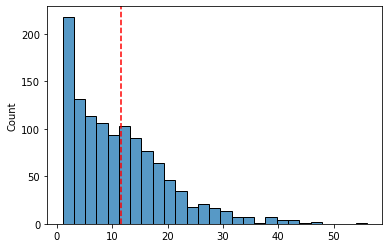

In [16]:
# histogram of point differentials
sns.histplot(data['WScore']-data['LScore'])
plt.axvline(x=(data['WScore']-data['LScore']).mean(),
            color='red', ls='--')

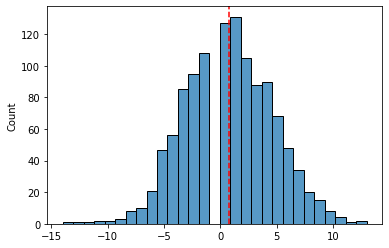

In [17]:
# histogram of 3 point make differentials
sns.histplot(data['WFGM3']-data['LFGM3'])
plt.axvline(x=(data['WFGM3']-data['LFGM3']).mean(),
            color='red', ls='--')

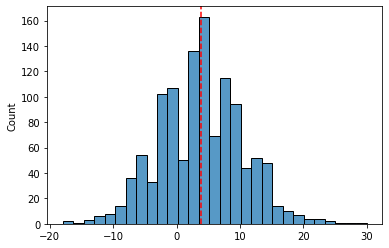

In [18]:
# histogram of free throw make differentials
sns.histplot(data['WFTM']-data['LFTM'])
plt.axvline(x=(data['WFTM']-data['LFTM']).mean(),
            color='red', ls='--')

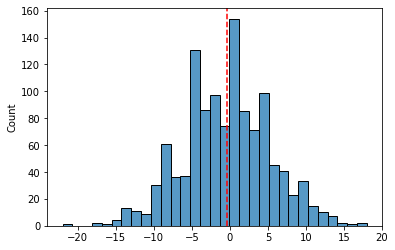

In [19]:
# histogram of offensive rating differentials
sns.histplot(data['WOR']-data['LOR'])
plt.axvline(x=(data['WOR']-data['LOR']).mean(),
            color='red', ls='--')

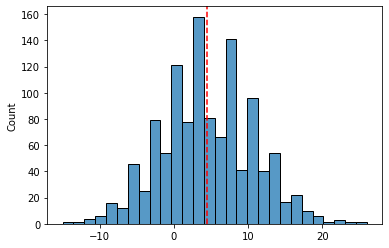

In [20]:
# histogram of defensive rating differentials
sns.histplot(data['WDR']-data['LDR'])
plt.axvline(x=(data['WDR']-data['LDR']).mean(),
            color='red', ls='--')

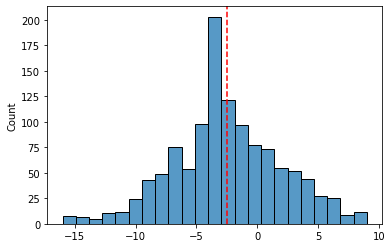

In [21]:
# histogram of personal foul differentials
sns.histplot(data['WPF']-data['LPF'])
plt.axvline(x=(data['WPF']-data['LPF']).mean(),
            color='red', ls='--')

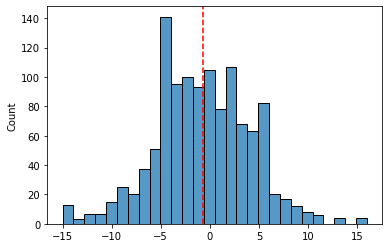

In [22]:
# histogram of turnover differentials
sns.histplot(data['WTO']-data['LTO'])
plt.axvline(x=(data['WTO']-data['LTO']).mean(),
            color='red', ls='--')

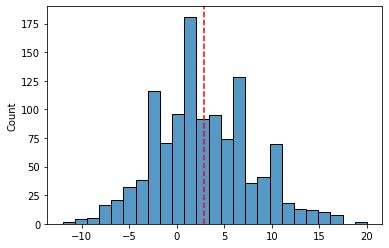

In [23]:
# histogram of assist differentials
sns.histplot(data['WAst']-data['LAst'])
plt.axvline(x=(data['WAst']-data['LAst']).mean(),
            color='red', ls='--')

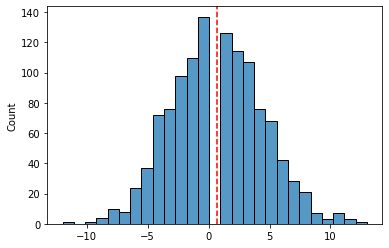

In [24]:
# histogram of steal differentials
sns.histplot(data['WStl']-data['LStl'])
plt.axvline(x=(data['WStl']-data['LStl']).mean(),
            color='red', ls='--')

### EDA of Season Data Stat Differentials

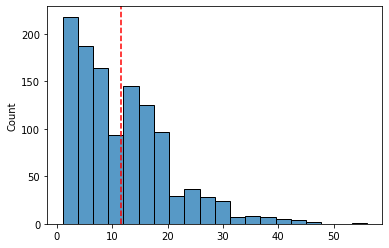

In [25]:
# histogram of point differentials
sns.histplot(data['WScore']-data['LScore'], bins=20)
plt.axvline(x=(data['WScore']-data['LScore']).mean(),
            color='red', ls='--')

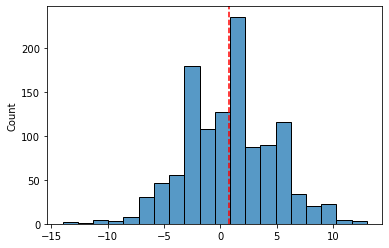

In [26]:
# histogram of 3 point make differentials
sns.histplot(data['WFGM3']-data['LFGM3'], bins=20)
plt.axvline(x=(data['WFGM3']-data['LFGM3']).mean(),
            color='red', ls='--')

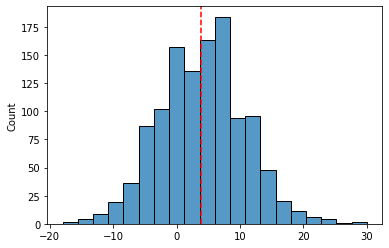

In [27]:
# histogram of free throw make differentials
sns.histplot(data['WFTM']-data['LFTM'], bins=20)
plt.axvline(x=(data['WFTM']-data['LFTM']).mean(),
            color='red', ls='--')

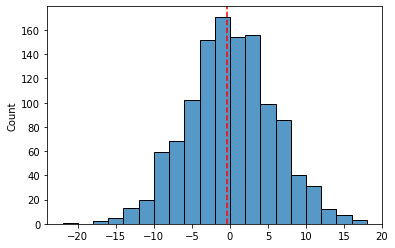

In [28]:
# histogram of offensive rating differentials
sns.histplot(data['WOR']-data['LOR'], bins=20)
plt.axvline(x=(data['WOR']-data['LOR']).mean(),
            color='red', ls='--')

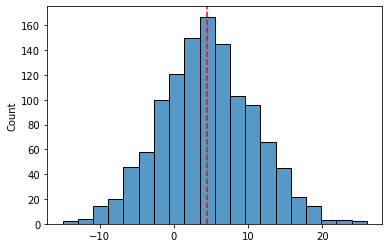

In [29]:
# histogram of defensive rating differentials
sns.histplot(data['WDR']-data['LDR'], bins=20)
plt.axvline(x=(data['WDR']-data['LDR']).mean(),
            color='red', ls='--')

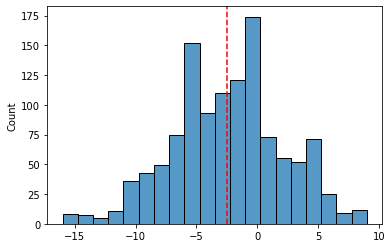

In [30]:
# histogram of personal foul differentials
sns.histplot(data['WPF']-data['LPF'], bins=20)
plt.axvline(x=(data['WPF']-data['LPF']).mean(),
            color='red', ls='--')

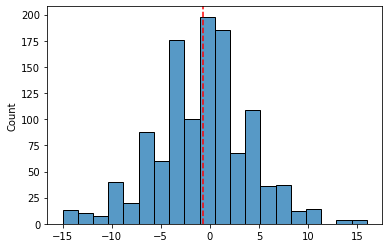

In [31]:
# histogram of turnover differentials
sns.histplot(data['WTO']-data['LTO'], bins=20)
plt.axvline(x=(data['WTO']-data['LTO']).mean(),
            color='red', ls='--')

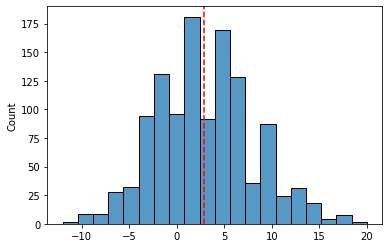

In [32]:
# histogram of assist differentials
sns.histplot(data['WAst']-data['LAst'], bins=20)
plt.axvline(x=(data['WAst']-data['LAst']).mean(),
            color='red', ls='--')

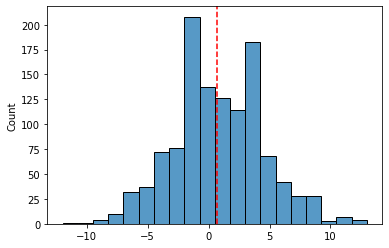

In [33]:
# histogram of steal differentials
sns.histplot(data['WStl']-data['LStl'], bins=20)
plt.axvline(x=(data['WStl']-data['LStl']).mean(),
            color='red', ls='--')

From the EDA we can see that most of the variables in both the tournament and regular season data take roughly a normal distribution. This shows that the data is reliable and also that we have enough observations of each variable to be able to properly train and test our model.

# Proposed Solution

With the above mentioned data, we propose to build a classification predictive model using NCAA regular season and March Madness data with the aim of accurately predicting individual game outcomes. We experimented with both logistic regression and gradient boosted decision tree classifiers and determined that logistic regression provided the highest accuracy. We then trained and tuned our logistic regression classification model which was trained by comparing team statistics for an individual match to the outcome of that match. As we developed the model, variables with high correlation to match outcome were removed from the analysis to reduce their influence. Once we created our trained model, we tested it on the rest of data that wasn't used for training. The model was given a team and its statistics for a given match and then tasked with predicting the outcome of that match. After this classification was performed on all the test data, we calculated the accuracy, recall, and precision generated from all of the true positives, false positives, true negatives, and false negatives. These three metrics were our main metrics that were used to measure the success of the model.

# Evaluation Metrics

The main evaluation metrics that we used to determine the success of our model were accuracy, recall and precision. These three statistics each represent a different aspect of how well the model classified the data, and together they come together to show how well the model performed at overall classification.

Accuracy was determined by dividing the number of correct predictions by the total number of predictions. This metric gave us a general idea of how well the model performed when it came to correctly predicting both match wins and match losses.

Recall was determined by dividing the number of correctly predicted match wins by the total number of matches that were wins (true positives + false negatives). This metric helped us to determine what percentage of match wins were correctly classified as wins compared to match wins that were misclassified as losses.

Precision was calculated by dividing the number of correctly predicted match wins by the total number of predicted wins. This metric helped us to determine what percentage of the model's predicted wins were actual wins.

# Results

# Preliminary Model Testing and Selection
This section will cover the preliminary testing that we did with both the logistic regression and gradient boosted decision tree classifiers to determine which would be the best for our model. These two classification algorithms were chosen because our research into preexisting bracket predictors indicated that logistic regression and gradient boosted decision trees typically have the highest accuracy. 

## Logistic Regression
Starting with logistic regression, the data for each match was split by winning team and losing team and the win and loss data were put in separate dataframes. One dataframe contained all the win data and one dataframe contained all the loss data so that win and loss data was not mixed and in turn the data was easier to use.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [35]:
# https://www.kaggle.com/c/mens-march-mania-2022/data

# regular season data
data_regszn = pd.read_csv('MRegularSeasonDetailedResults.csv')

# tournament data
data_tournament = pd.read_csv('MNCAATourneyDetailedResults.csv')

In [36]:
data_regszn.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [37]:
data_tournament.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [39]:
combined_data = pd.concat([data_regszn, data_tournament])

In [40]:
# extract all game stats of the winning team
# year, daynum, teamID, and numOT ignored
wins_data = combined_data[['WScore', 'WLoc', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 
                  'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

wins_data.rename(columns = {'WScore':'Score', 
                            'WLoc':'Loc',
                            'WFGM':'FGM',
                            'WFGA':'FGA',
                            'WFGM3':'FGM3',
                            'WFGA3':'FGA3',
                            'WFTM':'FTM',
                            'WFTA':'FTA',
                            'WAst':'Ast',
                            'WOR':'OR',
                            'WDR':'DR',
                            'WTO':'TO',
                            'WStl':'Stl',
                            'WBlk':'Blk',
                            'WPF':'PF'
                           }, inplace = True)

wins_data['Won'] = 1

wins_data['Loc'] = wins_data['Loc'].map({'H':1, 'N':0, 'A':-1})

/tmp/ipykernel_1680/3365504104.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_data.rename(columns = {'WScore':'Score',
/tmp/ipykernel_1680/3365504104.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_data['Won'] = 1
/tmp/ipykernel_1680/3365504104.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_da

In [41]:
# do the same thing for losses
# there is no LLoc, only WLoc, so reverse it when mapping
losses_data = combined_data[['LScore', 'WLoc', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                  'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

losses_data.rename(columns = {'LScore':'Score', 
                            'WLoc':'Loc',
                            'LFGM':'FGM',
                            'LFGA':'FGA',
                            'LFGM3':'FGM3',
                            'LFGA3':'FGA3',
                            'LFTM':'FTM',
                            'LFTA':'FTA',
                            'LAst':'Ast',
                            'LOR':'OR',
                            'LDR':'DR',
                            'LTO':'TO',
                            'LStl':'Stl',
                            'LBlk':'Blk',
                            'LPF':'PF'
                           }, inplace = True)

losses_data['Won'] = 0

losses_data['Loc'] = losses_data['Loc'].map({'H':-1, 'N':0, 'A':1})

/tmp/ipykernel_1680/408430235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_data.rename(columns = {'LScore':'Score',
/tmp/ipykernel_1680/408430235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_data['Won'] = 0
/tmp/ipykernel_1680/408430235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses

After isolating all of the win and loss data, it was then moved to a single dataframe for ease of access as in the cell seen below. This dataframe is different from the original because each team in each match is represented as a separate row rather than having both the winning and losing team's data in the same row. With each row now containing only one team's outcome in an individual match, the data is now represented in a way that can be processed by the logistic regression classifier. The data was then shuffled to prevent the order of the data having an effect on the result.

In [42]:
# combine wins and losses dataframes
data = pd.concat([wins_data, losses_data])

# shuffle data
data = data.sample(frac = 1)

data.head()

,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Won
48006,62,1,26,51,0,4,10,17,8,28,16,19,9,7,17,1
14976,52,-1,23,57,4,12,2,6,11,25,16,19,2,3,25,0
2574,60,1,22,49,4,11,12,17,8,18,13,9,6,2,10,1
52732,49,-1,18,45,3,14,10,19,8,20,6,15,8,2,8,0
85621,71,-1,22,53,4,21,23,27,12,17,11,18,11,3,26,0


## Controlling for variable correlation
Before inputting the data into the model, each variable's correlation to match wins was calculated and displayed in a heatmap. To prevent variables that are highly correlated with match wins from having confounding effects on the results of the model, the variables with high correlation values were removed from the analysis.

In [43]:
# sorts columns by correlation to wins
ix = data.corr().sort_values('Won', ascending=False).index
data = data.loc[:, ix]
data.columns

Index(['Won', 'Score', 'DR', 'Ast', 'FGM', 'FTM', 'Loc', 'FTA', 'Blk', 'FGM3',
       'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'],
      dtype='object')

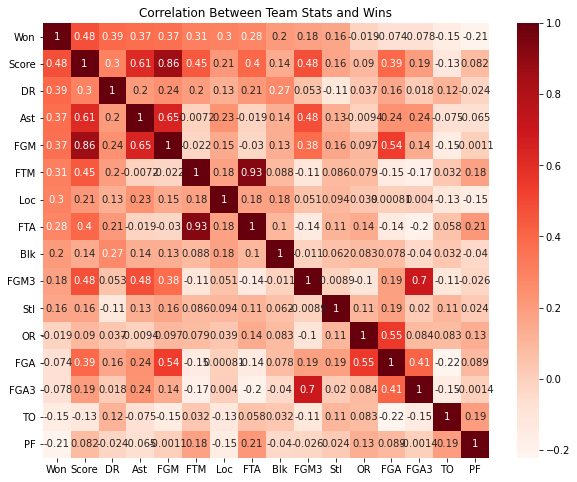

In [44]:
# heatmap to examine the correlation between team stats and wins
plt.figure(figsize=(10,8))
cor = data[['Won', 'Score', 'DR', 'Ast', 'FGM', 'FTM', 'Loc', 'FTA', 'Blk', 'FGM3',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'
                ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Between Team Stats and Wins')
plt.show()

## Finding the optimal number of parameters
Now that the data is fully prepared to be used in the model, a model was created using a train-test split of the data. To check how many of the variables should be included in the analysis, the accuracy, precision, and recall of a logistic regression model was calculated first with all the variables. Then, one variable was removed from the analysis and the evaluation metrics were calculated again. This process continued until only one variable remained, and the metrics were plotted for each number of variables. Through this analysis, it was determined that using all the variables would provide the best accuracy for the model.

In [45]:
# want to find optimal parameters

# removed highly correlated params
X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]
y = data['Won']

accuracy = []
recall = []
precision = []

for i in range(len(X.columns)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    clf = LogisticRegression(solver='saga', max_iter=1000).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))
    
    X.drop(columns=X.columns[-1], 
        axis=1, 
        inplace=True)

/tmp/ipykernel_1680/3145728692.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=X.columns[-1],
/tmp/ipykernel_1680/3145728692.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=X.columns[-1],
/tmp/ipykernel_1680/3145728692.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=X.columns[-1],
/tmp/ipykernel_1680/3145728692.py:25: SettingWithCopyWarning: 
A value is trying to be set on a c

Text(0.5, 1.0, 'Accuracy, Recall, and Precision for Predictor Combinations')

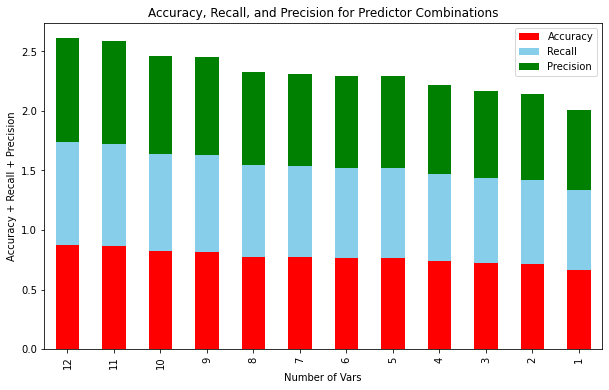

In [46]:
df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=['12', '11', '10', '9',
                       '8', '7', '6', '5', '4',
                       '3', '2', '1'])

df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('Number of Vars')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for Predictor Combinations')

In the above plot we can see that the full number of variables (12) provided the highest total of accuracy, recall and precision, so we continued our analysis with all 12 variables.

## Finding optimal regularization term and C value
Next we sought to find the optimal regularization term and C value for the logistic regression solver and classifier.

To find the optimal regularization term, the `elasticnet` penalty was used and `l1_ratio` values ranging from `0.0` (equivalent to l2 term) to `1.0` (equivalent to l1 term) were tested in steps of `0.1`. The evaluation metrics for each `l1_ratio` value were stored and the metric values were plotted.

In [47]:
# finding optimal regularization term
accuracy = []
recall = []
precision = []

X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]

# 0 = l2, 0.5 = half/half, 1.0 = l1
l1rs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for l1r in l1rs:
    clf = LogisticRegression(solver='saga', max_iter=1000, penalty = 'elasticnet', l1_ratio = l1r).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))

,Accuracy,Recall,Precision
0.0,0.870174,0.865851,0.873303
0.1,0.870204,0.865881,0.873334
0.2,0.870204,0.865941,0.873289
0.3,0.870189,0.865881,0.873307
0.4,0.870204,0.865881,0.873334
0.5,0.870204,0.865911,0.873311
0.6,0.870204,0.865881,0.873334
0.7,0.870204,0.865970,0.873266
0.8,0.870174,0.865851,0.873303
0.9,0.870174,0.865851,0.873303


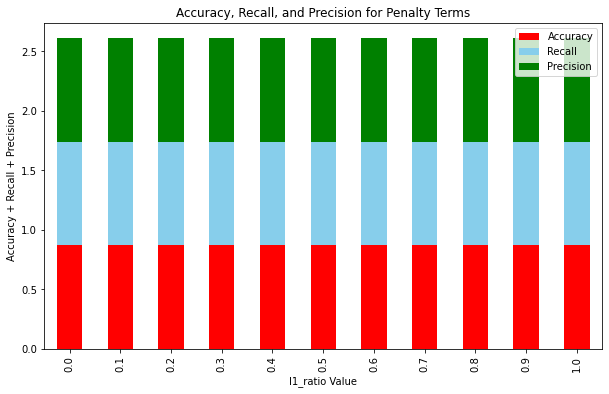

In [48]:
reg_df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=l1rs)

reg_df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('l1_ratio Value')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for Penalty Terms')

reg_df

From the results, it seemed as though any combination of the l1 and l2 regularization terms showed no significant difference from another. Our choice didn't matter too much, so we went with an `l1_ratio` value of `0.3` because its metric values were slightly better than the others.

Next, we sought to find an optimal C value for the logistic regression classifier. C values ranging from `0.01` to `100` were tested with no specific step size in between, and each value was tested in a logistic regression classifier using the same validation set.

In [49]:
# finding optimal C
accuracy = []
recall = []
precision = []

Cs = [0.01, 0.1, 0.5, 1.0, 5, 10, 50, 100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

for c in Cs:
    clf = LogisticRegression(solver='saga', penalty = 'elasticnet', l1_ratio = 0.3, max_iter=1000, C = c).fit(X_val, y_val)
    
    y_pred = clf.predict(X_val)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))

,Accuracy,Recall,Precision
0.01,0.866767,0.864613,0.869143
0.10,0.866943,0.864613,0.869450
0.50,0.866913,0.864613,0.869399
1.00,0.866943,0.864613,0.869450
5.00,0.866943,0.864613,0.869450
10.00,0.866943,0.864613,0.869450
50.00,0.866913,0.864555,0.869442
100.00,0.866913,0.864555,0.869442


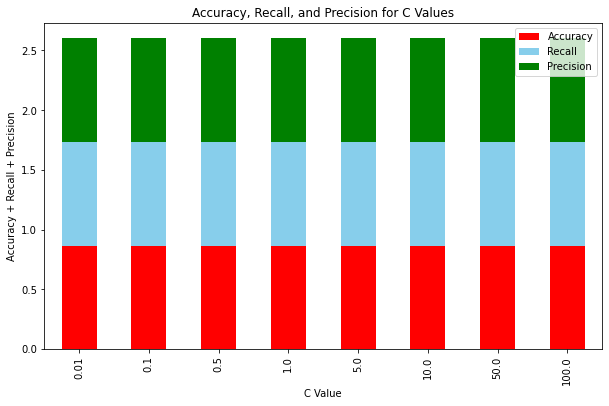

In [50]:
c_df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=Cs)

c_df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('C Value')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for C Values')

c_df

The difference in performance of each C value was not very significant, but a C value of `C = 5` pulled slightly ahead of all the others, so we decided to use that value moving forward.

# Gradient Boosted Decision Tree

We also attempted to fit multiple gradient boosting models with the training data using scikit-learn's prebuilt model as a baseline, as well as XGBoost (extreme gradient boosting) and LightGBM (light gradient boost) to increase efficiency and hopefully accuracy.

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
python -m pip install xgboost
import xgboost
import lightgbm as lgb

SyntaxError: invalid syntax (227228499.py, line 3)

In [ ]:
# sklearn implementation
gbc = GradientBoostingClassifier()
gbc_params = {
              'max_features': [None],
              'loss': ['deviance'],
              'n_estimators': [150],
              'max_depth': [3],
              'min_samples_leaf': [220],
              'min_samples_split': [2],
              'learning_rate': [0.1],
              'criterion': ['friedman_mse'],
              'min_weight_fraction_leaf': [0],
              'subsample': [1],
              'max_leaf_nodes': [16],
              'min_impurity_decrease': [0.2],
             }
gbc_grid = GridSearchCV(gbc, param_grid = gbc_params, cv=5, verbose=1, n_jobs =-1)
gbc_grid.fit(X_train, y_train)
gbc_grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# XGBoost implementation
xgb = xgboost.XGBClassifier()
xgb_params = {
              'max_depth': [5],
              'learning_rate': [0.05],
              'n_estimators': [300],
              'gamma': [.65],
              'min_child_weight': [3],
              'max_delta_step': [2],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'colsample_bylevel': [0.8],
              'reg_alpha': [0.1],
              'reg_lambda': [0.2],
              'scale_pos_weight' : [1],
              'base_score' : [0.5],
             }
grid = GridSearchCV(xgb, param_grid = xgb_params, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
# LightGBM implementation
lgbm = lgb.LGBMClassifier()
lgbm_params = {
               'num_boost_round': [70],
               'learning_rate': [.05],
               'num_leaves': [25],
               'num_threads': [4],
               'max_depth': [8],
               'min_data_in_leaf': [10],
               'feature_fraction': [1.0],
               'feature_fraction_seed': [95],
               'bagging_freq': [0],
               'bagging_seed': [95],
               'lambda_l1': [0.0],
               'lambda_l2': [0.0],
               'min_split_gain': [0],
             }
lgbm_grid = GridSearchCV(lgbm, param_grid = lgbm_params, cv=5, verbose=1)
lgbm_grid.fit(X_train, y_train)
lgbm_grid.best_score_

Looking at the three models, all three have about the same score varying by two accuracy points. Even when changing parameter values (in some cases to extreme outliers), the accuracy does not vary too much. Since the best scores of all our models do not outperform the average for our Logistic Regresion models, we decided to utilize Logistic Regression for our prediction model.

# Finalizing our model and tuning hyperparameters
In order to estimate the final performance of our model, we ran a KFold cross-validator with 10 splits on the model with the regularization term and C value that we determined in the previous section. The evaluation metrics for each fold were then stored, and the average of each metric was taken after the KFold completed. The average values of each evaluation metric can be seen below.

In [56]:
# estimating final performance using kfold 

kf = KFold(n_splits=10, shuffle=True, random_state=43)
X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]
y = data['Won']

accuracy = []
recall = []
precision = []
coef_vals = np.zeros(len(['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']))

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = LogisticRegression(solver='saga', max_iter=1000, C = 5, 
                             penalty = 'elasticnet', l1_ratio = 0.3).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))
    
    for i in range(len(np.array(clf.coef_)[0])):
        coef_vals[i] += np.array(clf.coef_)[0][i]

In [57]:
print("Average accuracy:")
print(np.mean(accuracy))
print("Average recall:")
print(np.mean(recall))
print("Average precision:")
print(np.mean(precision))

Average accuracy:
0.8692374304325032
Average recall:
0.8672078944059208
Average precision:
0.870732480895254


From the results of the KFold, we were able to determine optimal values for each hyperparameter coefficient in order to maximize the accuracy of the model. The value of each hyperparameter coefficient can be seen below.

In [58]:
# look at which coefficients are most important

coef_df = pd.DataFrame({'Coef': ['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'], 
           'Weight': coef_vals})

coef_df.reindex(coef_df.Weight.abs().sort_values().index).iloc[::-1]

,Coef,Weight
2,FGM,4.752999
8,FGA,-4.217994
6,Stl,3.967692
0,DR,3.642098
7,OR,3.370019
10,TO,-3.355087
3,Loc,2.278810
11,PF,-1.066163
1,Ast,0.818448
5,Blk,0.693109


# Discussion

### Interpreting the result

Our final logistic regression model was able to achieve 86.9% accuracy, 86.7% recall, and 87.1% precision over a substantial dataset, a sign that it can effectively tackle the problem of predicting NCAA games. We were able to accomplish this by using 12 different predictor variables. The predictors most relevant to determining a win/loss were field goals made, field goals attempted, steals, and defensive rating, while the least relevant included free throws attempted and three point field goals attempted. We compared our logistic regression model to gradient-boosted decision trees, and found gradient-boosted trees to be effective but slightly less accurate at roughly 85%. Although logistic regression seemed to work well for our dataset, there are some generalization concerns due to the training data that we will explore in the next section. Additionally, even after tweaking hyperparameters and experimenting with different predictor combinations, our accuracy never went higher than 86.9% or much lower. It’s unclear why this value seemed to be our ceiling, and we would need rigorous testing to see if it’s the maximum accuracy for other models, but the high potential for variability in an NCAA game makes it unlikely that any model could do significantly better. For example, the risk of players getting injured, bad shooting nights, or just high pressure environments getting to players mentally could all swing the outcome on any given night, limiting the power of these models.

### Limitations

The dataset we used was limited in its capacity to predict March Madness games in two key ways. First, the majority of the data was from regular season games, not March Madness games. Since March Madness games are higher stakes, and therefore higher pressure, it may be difficult to generalize trends discovered in the regular season to the playoffs. Second, although March Madness games are played on neutral courts (neither team’s home court), some courts are closer to one team’s school, making it more convenient for their fans to show up. This could very well have an impact on player morale, but our model fails to capture this due to the shortcomings of the dataset. If we had a dataset that included each team’s distance from their school to the arena, as well as more playoff data overall, then our model would be much more accurate and generalizable. 

### Ethics & Privacy

Since our model will be using data from nationally televised basketball games, it is unlikely that privacy will be a major concern due to the immense popularity of the March Madness tournament. In terms of ethical implications, there is always a possibility that our model will be biased in choosing certain types of teams over others. It is important that we are cognizant of this and the impact it could have on collegiate athletes’ careers. For example, if our model found that teams with taller players were more likely to win the championship, colleges who use the model might start giving more scholarships to taller players and less to shorter players. This would limit opportunities for short players, even if they are skilled and could contribute to a winning team. We must ensure that our model is as accurate as possible in order to minimize the chance of unfairly affecting players’ opportunities. One way to do this is to only focus on team stats, which would decrease the chance of creating a model that overfits to players’ attributes. However, if our model is used by collegiate recruiters, there is no way to fully prevent them from giving scholarships to players with skills that the model favors (for instance, if the model favors team three point shooting, then recruiters might recruit more three point specialists).

### Conclusion

In selecting a predictor model aimed at producing an accurate March Madness bracket, our final logistic regression model outperformed gradient-boosted trees by a slight margin. The lack of variation in accuracy across both models regardless of selected outlier parameters however points to a noticeable over generalization in our data which contains a majority of regular season D1 NCAA games. As a result, it appears that regardless of the model selected for our chosen data set its accuracy value after parameter tuning would not vary significantly in comparison to other models as outlier parameter testing yielded very similar accuracies(~1-3% variation). 
 
However, using logistic regression we were able to identify different weightings in terms of importance in determining winning or losing for our selected predictor variables that could prove useful to extrapolate and build upon in future research that could potentially result in an increase of accuracy, recall, and or precision. 

# Footnotes
<a name="wilconote"></a>1.[^](#wilco): Wilco, D. (4 Jan 2022) March Madness History - The ultimate guide. NCAA.com
https://www.ncaa.com/news/basketball-men/article/2021-03-14/march-madness-history-ultimate-guide<br> 
<a name="gotonote"></a>2.[^](#goto): Goto, K. (7 Apr 2021) Predicting March Madness Using Machine Learning. towardsdatascience.com https://towardsdatascience.com/kaggle-march-madness-silver-medal-for-two-consecutive-years-6207ff63b86c<br>
<a name="piercenote"></a>3.[^](#pierce): Pierce, A., Weininger, L. (21 Apr 2019)  How We Predicted March Madness Using Machine Learning. medium.com
https://lotanweininger.medium.com/march-madness-machine-learning-2dbacc948874